## Import Required Libraries

In [1]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.pandas as pd
from matplotlib import pyplot as plt
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.classification import LogisticRegression, NaiveBayesModel, MultilayerPerceptronClassifier, NaiveBayes, MultilayerPerceptronClassificationModel, LogisticRegressionModel
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.ml.functions import vector_to_array
from sklearn.preprocessing import MultiLabelBinarizer

/opt/homebrew/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


### Create a Spark Session

In [2]:
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/03 22:35:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read the dataset csv file into the program

In [3]:
data = spark.read.format('csv').option("header", "True").load("./dataset/playerData.csv")

## Data Cleaning

In [4]:
def dataCleaning(data):
    data = data.withColumn("Wage", regexp_replace(data["Wage"], "[^0-9]+", ""))
    data = data.withColumnRenamed("Wage", "Wage in Millions")
    data = data.withColumn("Value", regexp_replace(data["Value"], "[^0-9]+", ""))
    data = data.withColumnRenamed("Value", "Value in Thousands")

    def evaluateAttr(val):
        return eval(val)
    
    evaluateAttribute = udf(lambda x: evaluateAttr(x), IntegerType())
    
    cols = ['Age','overall','potential','Wage in Millions', 'Value in Thousands', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys']
    for column in cols:
        data = data.withColumn(column,evaluateAttribute(column))
        
    for column in cols:
        data = data.withColumn(column,data[column].cast("Integer"))

    data.na.fill(value=0)
    
    defenders = ['LWB', 'RWB', 'CB', 'LB', 'RB', 'GK']
    midfielders = ['LM', 'CM', 'RW', 'CDM']
    strikers = ['LW','CAM', 'CF', 'ST']
    
    def getPosition(pos):
        if pos in defenders:
            return "Defender"
        elif pos in midfielders:
            return "Midfielder"
        else:
            return "Striker"
        
    convergePosition = udf(lambda x:getPosition(x),StringType())
        
    data = data.withColumn("Pos", convergePosition("Position"))
    return data

In [5]:
data = dataCleaning(data)

## Data Descriptions

In [6]:
data.count()

17981

In [7]:
pd.DataFrame(data.describe())

23/05/03 22:35:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Name,Age,Nationality,overall,potential,Club,Value in Thousands,Wage in Millions,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,Position,Pos
0,count,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981,17981
1,mean,None,25.144541460430453,None,66.24798398309326,71.19081252433124,None,271.90617874423003,11.546966242144485,64.6073077136978,55.83499249207497,63.34558700850898,63.81836382848562,58.11968188643568,57.903119959957735,49.79150214114899,47.328124131027195,55.076580835326176,45.3064345698237,43.19259218063512,16.73872420888716,16.515154885712697,16.392747900561705,16.502474834547577,16.86880596184862,52.34608753684444,46.57299371558868,64.9051220732996,52.471164006451254,47.229464434681056,44.117457316055834,48.991546632556584,49.66442355820032,61.91023858517324,58.31722373616595,55.670986040820864,45.582559368222014,64.84244480284745,63.27217618597408,47.45687114176075,65.29736944552583,53.03242311328625,43.232189533396365,None,None
2,stddev,None,4.614272345005111,None,6.987965339747416,6.102199325567335,None,280.73692302804375,23.080000138571588,14.916971170718051,17.48081647218318,14.794278052287048,14.098143947025351,16.800909128065054,12.93410877909096,18.47021975728735,18.476582400389493,18.99382188090322,19.48156703513917,17.59918034115996,17.7934455166947,17.016701735276627,16.608172422955004,17.131590325756054,18.087261468614727,17.412957370472316,20.693081933807278,11.888605462219818,15.545935196771936,19.29169455623551,21.582217181072384,15.818303550058353,19.442870209625244,9.179489169715767,14.928462255248872,17.40783062104216,21.491756303804635,14.654376785159618,15.942077388636944,21.84192349589622,12.622276169730286,14.396201485247206,17.739678583808775,None,None
3,min,A. Abbas,16,Afghanistan,46,46,SSV Jahn Regensburg,0,0,11,11,14,11,8,5,5,6,2,2,4,1,1,1,1,1,4,4,13,7,3,4,5,2,28,10,3,4,11,12,4,12,10,4,CAM,Defender
4,max,Ã€ngel Rangel,47,Zimbabwe,94,94,ÅšlÄ…sk WrocÅ‚aw,975,565,96,106,96,96,95,100,101,92,97,95,96,91,91,95,91,90,94,92,95,93,92,92,92,95,96,92,98,95,110,116,99,98,94,91,ST,Striker


In [8]:
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Value in Thousands: integer (nullable = true)
 |-- Wage in Millions: integer (nullable = true)
 |-- Acceleration: integer (nullable = true)
 |-- Aggression: integer (nullable = true)
 |-- Agility: integer (nullable = true)
 |-- Balance: integer (nullable = true)
 |-- Ball control: integer (nullable = true)
 |-- Composure: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Curve: integer (nullable = true)
 |-- Dribbling: integer (nullable = true)
 |-- Finishing: integer (nullable = true)
 |-- Free kick accuracy: integer (nullable = true)
 |-- GK diving: integer (nullable = true)
 |-- GK handling: integer (nullable = true)
 |-- GK kicking: integer (nullable = true)
 |-- GK positioning: integer (nullable = true)
 |-- GK reflexes:

## Data Visualization

In [9]:
country_df = data.select("Nationality").groupBy("Nationality").count().sort(desc("count"))
country_df = pd.DataFrame({"Nationality": country_df.toPandas()["count"].to_numpy()}, index = country_df.toPandas()["Nationality"].to_numpy())
country_df.plot.line(title="Plotting players by Nationality")


In [10]:
overall_df = data.select("Nationality", "overall").where(data["overall"] > 80).groupBy("Nationality").count().sort(desc("count")).toPandas()
overall_df = pd.DataFrame({"Nationality": overall_df["count"].to_numpy()}, index = overall_df["Nationality"].to_numpy(), )
overall_df.plot.bar(title="Plotting top Countries with Players above 80 overall")

In [11]:
# data.toPandas().sort_values(by=['Wage in Millions']).plot(kind="scatter",x="Wage in Millions",y="overall",figsize=(30,10), yticks=np.arange(0, 100, 5), xticks=np.arange(0,600, 10), color="green", marker='x')
scatter_df = pd.DataFrame({"Wage In Millions" : data.toPandas()["Wage in Millions"].to_numpy(), "overall" : data.toPandas()["overall"].to_numpy()})
scatter_df.plot.scatter(x="Wage In Millions", y="overall", title="Plotting Player Wage in Millions vs Ability")

In [12]:
cols = ['Name','Age','overall','potential','Wage in Millions', 'Value in Thousands', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing']
player_df = data.where(data.overall >= 90).select(cols).sort(desc("overall"))
player_df = pd.DataFrame(player_df.toPandas())
player_df = player_df.set_index("Name")
player_df.plot.line(title="Plotting Players with 90+ Overall and their Abilities")

### Comparing Characteristics of Defenders and Midfielders

In [13]:
categories = ['Acceleration','Sliding tackle','Standing tackle',
              'Sprint Speed', 'Composure', 'Aggression', 'Finishing', 'Interceptions', 'Curve']

defenderAttributes = [data.filter(data['Pos'] == 'Defender').agg({"Acceleration": "avg"}).toPandas()["avg(Acceleration)"][0], 
                      data.filter(data['Pos'] == 'Defender').agg({"Sliding tackle": "avg"}).toPandas()["avg(Sliding tackle)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Standing tackle": "avg"}).toPandas()["avg(Standing tackle)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Sprint Speed": "avg"}).toPandas()["avg(Sprint Speed)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Composure": "avg"}).toPandas()["avg(Composure)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Aggression": "avg"}).toPandas()["avg(Aggression)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Finishing": "avg"}).toPandas()["avg(Finishing)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Interceptions": "avg"}).toPandas()["avg(Interceptions)"][0],
                      data.filter(data['Pos'] == 'Defender').agg({"Curve": "avg"}).toPandas()["avg(Curve)"][0]]

midfielderAttributes = [data.filter(data['Pos'] == 'Midfielder').agg({"Acceleration": "avg"}).toPandas()["avg(Acceleration)"][0], 
                      data.filter(data['Pos'] == 'Midfielder').agg({"Sliding tackle": "avg"}).toPandas()["avg(Sliding tackle)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Standing tackle": "avg"}).toPandas()["avg(Standing tackle)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Sprint Speed": "avg"}).toPandas()["avg(Sprint Speed)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Composure": "avg"}).toPandas()["avg(Composure)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Aggression": "avg"}).toPandas()["avg(Aggression)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Finishing": "avg"}).toPandas()["avg(Finishing)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Interceptions": "avg"}).toPandas()["avg(Interceptions)"][0],
                      data.filter(data['Pos'] == 'Midfielder').agg({"Curve": "avg"}).toPandas()["avg(Curve)"][0]]

strikerAttributes = [data.filter(data['Pos'] == 'Striker').agg({"Acceleration": "avg"}).toPandas()["avg(Acceleration)"][0], 
                      data.filter(data['Pos'] == 'Striker').agg({"Sliding tackle": "avg"}).toPandas()["avg(Sliding tackle)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Standing tackle": "avg"}).toPandas()["avg(Standing tackle)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Sprint Speed": "avg"}).toPandas()["avg(Sprint Speed)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Composure": "avg"}).toPandas()["avg(Composure)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Aggression": "avg"}).toPandas()["avg(Aggression)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Finishing": "avg"}).toPandas()["avg(Finishing)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Interceptions": "avg"}).toPandas()["avg(Interceptions)"][0],
                      data.filter(data['Pos'] == 'Striker').agg({"Curve": "avg"}).toPandas()["avg(Curve)"][0]]

# fig = go.Figure()
fig = make_subplots(rows = 1, cols = 2, specs=[[{"type": "Scatterpolar"}, {"type": "Scatterpolar"}]])
fig.add_trace(go.Scatterpolar(
      r = defenderAttributes,
      theta=categories,
      fill='toself',
      name='Defenders'
),1,1)
fig.add_trace(go.Scatterpolar(
      r = midfielderAttributes,
      theta=categories,
      fill='toself',
      name='Midfielders'
),1,1)

fig.add_trace(go.Scatterpolar(
      r = midfielderAttributes,
      theta=categories,
      fill='toself',
      name='Midfielders'
),1,2)

fig.add_trace(go.Scatterpolar(
      r = strikerAttributes,
      theta=categories,
      fill='toself',
      name='Strikers'
),1,2)


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  title_text = "Plotting similarities Between Defenders, Strikers and Midfielders"
)

fig.show()

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r = defenderAttributes,
      theta=categories,
      fill='toself',
      name='Defenders'
))

fig.add_trace(go.Scatterpolar(
      r = strikerAttributes,
      theta=categories,
      fill='toself',
      name='Strikers'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  title_text = "Plotting similarities Between Different Defenders and Strikers"
)

fig.show()

In [15]:
def absolute_value(val):
    return np.round(val/100.* data.count(), 0)

## Data Cleaning Visualization

### Multiple Labels causing Issues in Predictions
    The Dataset contains 13 different labels as 13 different positions in which a player plays in the game of soccer
    As shown below there a very few samples available for some of the positions in the dataset which results in the predictions being highly skewed

In [16]:
complete_dataset = data.select("Position").groupBy("Position").count().toPandas()
complete_dataset = pd.DataFrame({"Position": complete_dataset["count"].to_numpy()}, index = complete_dataset.Position.to_numpy())
complete_dataset.plot.pie(y="Position", hole=0.3, title="Plotting Label Distribution of Complete Dataset")

### Solution

    To Eliminate this issue and improve the performance of the model we decided to converge players playing in strategically same positions into a single label.
    *   For Example, CB, LB and RB stand for
        -   CB = Center Back
        -   LB = Left Back
        -   RB = Right Back
    Now, the above mentioned positions are for defenders and usually have the same attributes.
    
    After grouping similar positions and bringing the label size down to 3 with the class labels being:

<img src="./plots/Player Positioning.png" />



In [17]:
updated_labels = data.select("Pos").groupBy("Pos").count().toPandas()
updated_labels = pd.DataFrame({"Position": updated_labels["count"].to_numpy()}, index = updated_labels.Pos.to_numpy())
updated_labels.plot.pie(y="Position", hole=0.3, title="Plotting Label Distribution of Updated Dataset")

### Plotting the dataset label distribution side-by-side gives us a much better idea about how the labels were merged

In [18]:
complete_dataset = data.select("Position").groupBy("Position").count().toPandas()
updated_labels = data.select("Pos").groupBy("Pos").count().toPandas()
fig = make_subplots(rows = 1, cols = 2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels = complete_dataset.Position.to_numpy(), values = complete_dataset["count"].to_numpy(), name="Total Dataset 13 Labels", title = "Total Dataset 13 Labels", titleposition="top center",),
              1, 1)
fig.add_trace(go.Pie(labels = updated_labels.Pos.to_numpy(), values = updated_labels["count"].to_numpy(), name="Total Dataset with 3 Labels", title = "Total Dataset with 3 Labels", titleposition="top center"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4)

fig.update_layout(
    title_text="Plotting Complete Dataset with Label Distribution")
fig.show()

## Data Modeling

In [19]:
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=123)

train = trainingData.select("Pos").groupBy("Pos").count().toPandas()
test = testData.select("Pos").groupBy("Pos").count().toPandas()

train_test_split = pd.DataFrame({'Train Data' : train["count"].to_numpy(),
              'Test Data' : test["count"].to_numpy()}, index= train.Pos.to_numpy())

train_test_split.plot.bar(barmode="group", title="Plotting Label Distribution for Train Test Split", text_auto=True)

In [20]:
fig = make_subplots(rows = 1, cols = 2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels = train.Pos.to_numpy(), values = train["count"].to_numpy(), name="Train Dataset", title = "Train Dataset"),
              1, 1)
fig.add_trace(go.Pie(labels = test.Pos.to_numpy(), values = test["count"].to_numpy(), name="Test Dataset", title = "Test Dataset"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4)

fig.update_layout(
    title_text="Plotting Label Distribution for Train Test Split")
fig.show()

## Data Pipeline

In [21]:
def createPipeline(cols):
    Nationality = StringIndexer(inputCol = 'Nationality', outputCol = 'Nationality_idx')
    label = StringIndexer(inputCol = 'Pos', outputCol = 'label')
    assembler = VectorAssembler(inputCols = cols, outputCol='features')
    pipeline= Pipeline(stages=[Nationality, label, assembler])

    return pipeline

In [22]:
cols = ['Nationality_idx','Age','overall','potential','Wage in Millions', 'Value in Thousands', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys']
pipeline = createPipeline(cols)
model = pipeline.fit(data).transform(data)

### The StringIndexer changes the Pos column which is also the label column with the following Mapping:
    1.  Defender   : 0
    2.  Striker    : 1
    3.  Midfielder : 2

In [23]:
model = model.select(model.features, model.label)
model.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[14.0,32.0,94.0,9...|  1.0|
|[4.0,30.0,93.0,93...|  2.0|
|[5.0,25.0,92.0,94...|  1.0|
|[28.0,30.0,92.0,9...|  1.0|
|[1.0,31.0,92.0,92...|  0.0|
|[17.0,28.0,91.0,9...|  1.0|
|[2.0,26.0,90.0,92...|  0.0|
|[24.0,26.0,90.0,9...|  1.0|
|[1.0,27.0,90.0,90...|  2.0|
|[4.0,29.0,90.0,90...|  1.0|
|[2.0,31.0,90.0,90...|  0.0|
|[24.0,26.0,89.0,9...|  1.0|
|[24.0,25.0,89.0,9...|  0.0|
|[12.0,28.0,89.0,8...|  1.0|
|[34.0,31.0,89.0,8...|  2.0|
|[32.0,27.0,89.0,8...|  2.0|
|[4.0,29.0,89.0,89...|  1.0|
|[6.0,32.0,89.0,89...|  0.0|
|[6.0,39.0,89.0,89...|  0.0|
|[4.0,23.0,88.0,93...|  1.0|
+--------------------+-----+
only showing top 20 rows



## Training Classifiers

In [24]:
def evaluateResults(ground_truth, pred, model):
    print(model + " Model Results")
    print(classification_report(ground_truth, pred))

In [25]:
def predFunctions(train, test, model):
    #logistic Regression Model
    print("Initiating Model")
    if model == 'Logistic-Regression':
        ml = LogisticRegression()
    # Naive-Bayes Model
    elif model == 'Naive-Bayes':
        ml = NaiveBayes(smoothing=1)
    elif model == 'Neural-network':
        # Define the layers of the neural network
        layers = [train.toPandas().features[0].size, 30, 30, 10, 3]
        ml = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, seed=1234, labelCol="label", solver="gd", stepSize=0.01, blockSize=100)
    else:
        return "Model not valid"
    
    print("Training Model")
    clf = ml.fit(train)
    clf.write().overwrite().save("./best-models/" + model)
    print("Testing Model")
    results = clf.transform(test)
    evaluateResults(results)
    return clf, results

In [26]:
(train, test) = model.randomSplit([0.8, 0.2], seed = 123)

In [27]:
def getPredictions(train, test):
    predFunctions(train, test, "Logistic-Regression")
    print("\n")
    predFunctions(train, test, "Random-Forest")
    print("\n")
    predFunctions(train, test, "Naive-Bayes")
    print("\n")
    predFunctions(train, test, "Neural-network")


## Analyze Results

In [28]:
lgRegressionModel = LogisticRegressionModel.load("./best-models/Logistic-Regression/")
neuralNetworkModel = MultilayerPerceptronClassificationModel.load("./best-models/Neural-network/")
NBModel = NaiveBayesModel.load("./best-models/Naive-Bayes/")

In [29]:
lgResults = lgRegressionModel.transform(test)
neuralNetworkResults = neuralNetworkModel.transform(test)
NBResults = NBModel.transform(test)

Logistic Regression Model Results


23/05/03 22:37:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


              precision    recall  f1-score   support

    Defender       0.89      0.91      0.90      1475
     Striker       0.74      0.74      0.74      1098
  Midfielder       0.64      0.62      0.63      1075

    accuracy                           0.77      3648
   macro avg       0.76      0.76      0.76      3648
weighted avg       0.77      0.77      0.77      3648



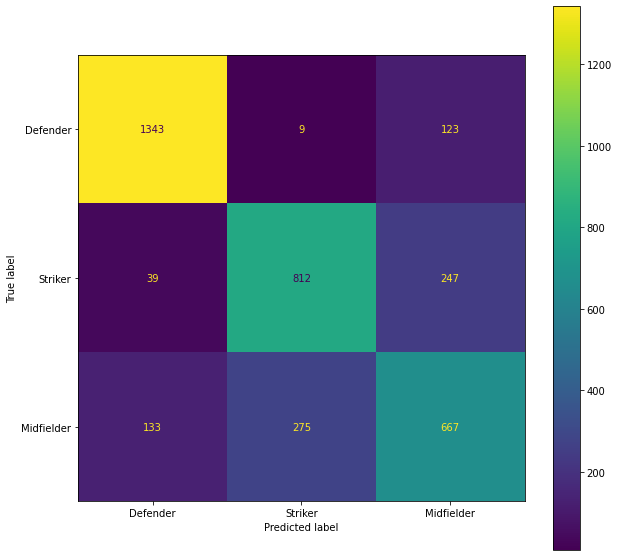

In [30]:
print("Logistic Regression Model Results")
pred_lr = lgResults.select("prediction").toPandas().prediction
ground_truth = test.toPandas().label
print(classification_report(ground_truth, pred_lr, target_names=["Defender", "Striker", "Midfielder"]))
disp = ConfusionMatrixDisplay(confusion_matrix(ground_truth, pred_lr), display_labels=["Defender", "Striker", "Midfielder"])
rcParams['figure.figsize'] = 10, 10
disp.plot()
plt.show()

Neural Network Model Results


              precision    recall  f1-score   support

    Defender       0.76      0.94      0.84      1475
     Striker       0.64      0.90      0.75      1098
  Midfielder       0.61      0.17      0.27      1075

    accuracy                           0.70      3648
   macro avg       0.67      0.67      0.62      3648
weighted avg       0.68      0.70      0.64      3648



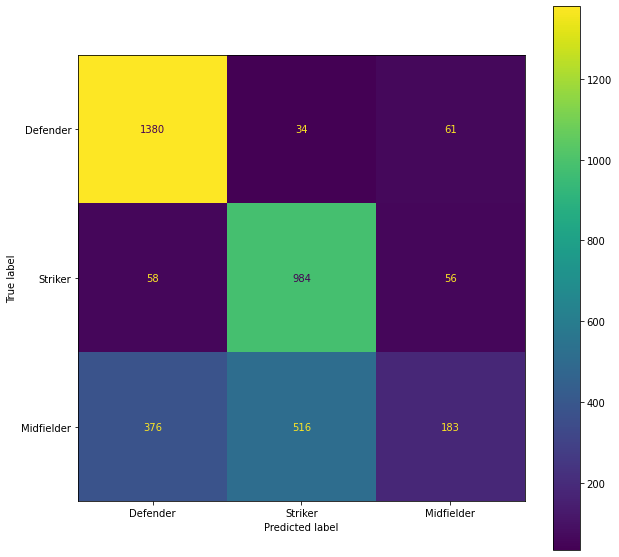

In [31]:
print("Neural Network Model Results")
pred_nn = neuralNetworkResults.toPandas().prediction
print(classification_report(ground_truth, pred_nn, target_names=["Defender", "Striker", "Midfielder"]))
disp = ConfusionMatrixDisplay(confusion_matrix(ground_truth, pred_nn), display_labels=["Defender", "Striker", "Midfielder"])
disp.plot()
plt.show()

Naive Bayes Model Results


              precision    recall  f1-score   support

    Defender       0.89      0.56      0.69      1475
     Striker       0.74      0.77      0.75      1098
  Midfielder       0.44      0.65      0.53      1075

    accuracy                           0.65      3648
   macro avg       0.69      0.66      0.66      3648
weighted avg       0.72      0.65      0.66      3648



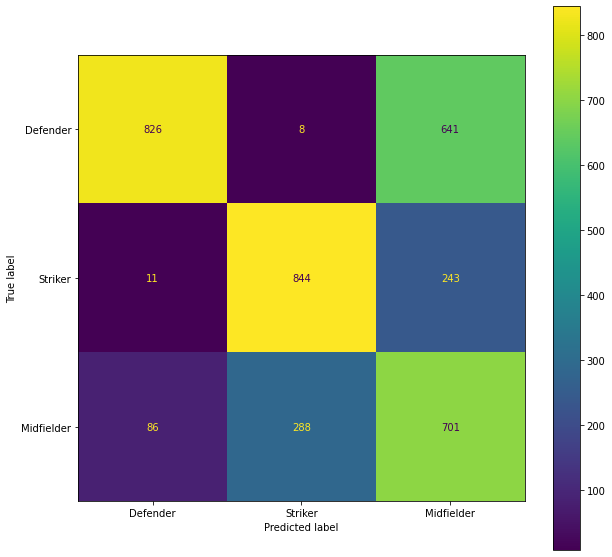

In [32]:
print("Naive Bayes Model Results")
pred_nb = NBResults.toPandas().prediction
print(classification_report(ground_truth, pred_nb, target_names=["Defender", "Striker", "Midfielder"]))
disp = ConfusionMatrixDisplay(confusion_matrix(ground_truth, pred_nb), display_labels=["Defender", "Striker", "Midfielder"])
disp.plot()
plt.show()

In [33]:
mb = MultiLabelBinarizer()
ground_truth_prob = mb.fit_transform(np.expand_dims(ground_truth.to_numpy(),1))

lr_probabilities = mb.fit_transform(np.expand_dims(pred_lr.to_numpy(),1))
nb_probabilities = mb.fit_transform(np.expand_dims(pred_nb.to_numpy(),1))
nn_probabilities = mb.fit_transform(np.expand_dims(pred_nn.to_numpy(),1))
ground_truth_arr = ground_truth.to_numpy()

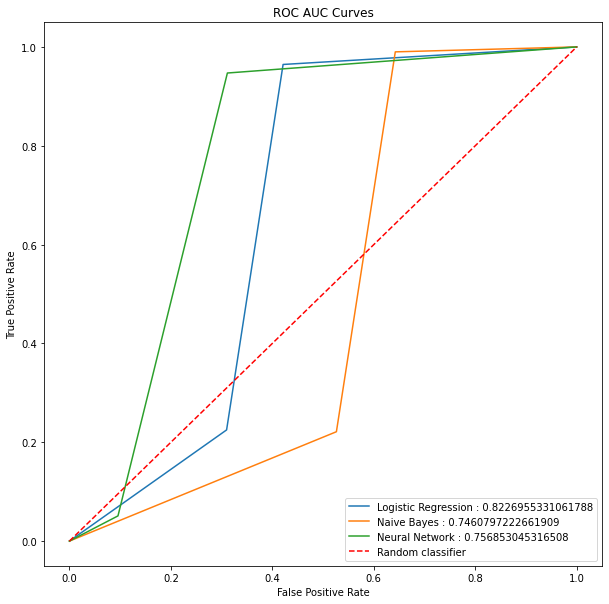

In [34]:
aucLogisticRegression = roc_auc_score(ground_truth_prob, lr_probabilities, multi_class='ovr')
aucNaiveBayes = roc_auc_score(ground_truth_prob, nb_probabilities, multi_class='ovr')
aucNeuralNetwork = roc_auc_score(ground_truth_prob, nn_probabilities, multi_class='ovr')

#create ROC curve
fpr, tpr, _ = roc_curve(ground_truth_arr, pred_lr.to_numpy(), pos_label = 1)
plt.plot(fpr, tpr, label = "Logistic Regression : " + str(aucLogisticRegression))

fpr, tpr, _ = roc_curve(ground_truth_arr, pred_nb, pos_label = 1)
plt.plot(fpr, tpr, label = "Naive Bayes : " + str(aucNaiveBayes))

fpr, tpr, _ = roc_curve(ground_truth_arr, pred_nn, pos_label = 1)
plt.plot(fpr, tpr, label = "Neural Network : " + str(aucNeuralNetwork))

plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("ROC AUC Curves")
plt.show()

### Conclusion
* Based on the visualizations above and the classification reports of each Machine Learning algorithm, we can see that Logistic regression is the best fit for this dataset with Naive bayes just falling short of a couple predictions.

* Neural Networks surprisingly could predict more Defenders and midfielders than the logistic regression however, failed to differentiate between Strikers and Midfielders.
This could be because of the fact that many factors for Strikers and Midfielders are same.

* Defenders usually have a separate set of characteristics which are different from Midfielders and Strikers which helps the models identify them appropriately